# Bandpass calibration demonstration

In [1]:
%matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = '/tmp/'

from matplotlib import pylab

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u

from matplotlib import pyplot as plt

from rascil.data_models import PolarisationFrame

from rascil.processing_components import create_blockvisibility, apply_gaintable, copy_visibility,\
    solve_gaintable, \
    create_gaintable_from_blockvisibility, show_image, create_test_image, simulate_gaintable, \
    create_named_configuration

from rascil.workflows.serial.imaging.imaging_serial import predict_list_serial_workflow

pylab.rcParams['figure.figsize'] = (8.0, 8.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

mpl_logger = logging.getLogger("matplotlib") 
mpl_logger.setLevel(logging.WARNING) 


Construct LOW core configuration

In [2]:
lowcore = create_named_configuration('LOWBD2-CORE')

create_named_configuration: LOWBD2-CORE
	(<Quantity -2565018.31203579 m>, <Quantity 5085711.90373391 m>, <Quantity -2861033.10788063 m>)
	GeodeticLocation(lon=<Longitude 116.76444824 deg>, lat=<Latitude -26.82472208 deg>, height=<Quantity 300. m>)
create_configuration_from_file: 166 antennas/stations


We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [3]:
times = numpy.zeros([1])
vnchan = 128
frequency = numpy.linspace(0.8e8, 1.2e8, vnchan)
channel_bandwidth = numpy.array(vnchan*[frequency[1]-frequency[0]])
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_blockvisibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

create_blockvisibility: created 1 times
create_blockvisibility: 1774208 rows, 0.100 GB


Read the venerable test image, constructing an image

import_image_from_fits: created >f8 image of shape (1, 1, 256, 256)
import_image_from_fits: Max, min in /Users/timcornwell/Code/rascil/data/models/M31_canonical.model.fits = 1.006458, 0.000000
replicate_image: replicating shape (1, 1, 256, 256) to (128, 1, 256, 256)


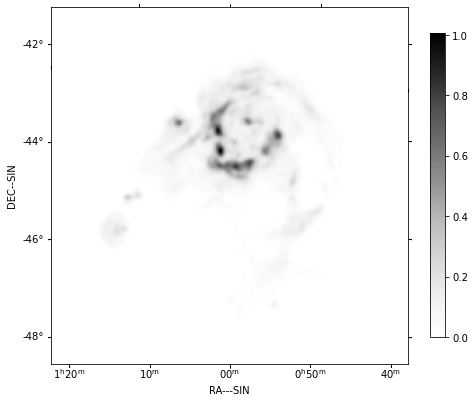

In [4]:
m31image = create_test_image(frequency=frequency, cellsize=0.0005,
                             phasecentre=phasecentre)
nchan, npol, ny, nx = m31image["pixels"].data.shape

fig=show_image(m31image)

In [5]:
print(m31image.image_acc.polarisation_frame)

stokesI


Predict the visibility from this image

In [6]:
vt = predict_list_serial_workflow([vt], [m31image], context='ng')[0]

Create a gain table with modest amplitude and phase errors, smoothed over 16 channels

In [8]:
gt = create_gaintable_from_blockvisibility(vt)
gt = simulate_gaintable(gt, phase_error=1.0, amplitude_error=0.1, smooth_channels=16)

simulate_gaintable: Simulating amplitude error = 0.1000, phase error = 1.0000


Plot the gains applied

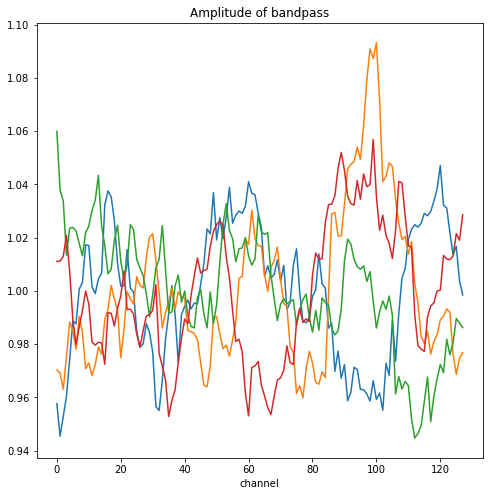

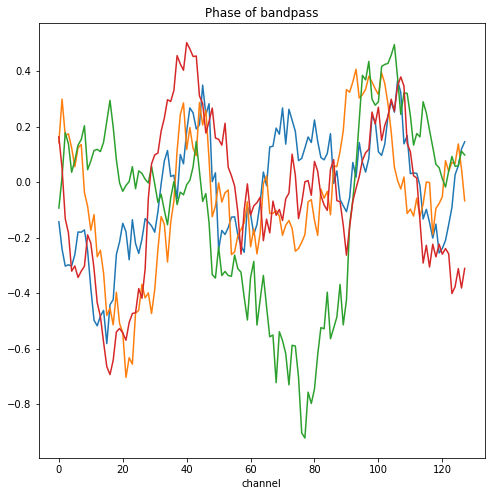

In [9]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    phase = numpy.angle(gt.gain[0,ant,:,0,0])
    plt.plot(phase)
plt.title('Phase of bandpass')
plt.xlabel('channel')
plt.show()


In [10]:
cvt = vt.copy(deep=True)
cvt = apply_gaintable(cvt, gt)

apply_gaintable: Apply gaintable
apply_gaintable: scalar gains


Solve for the gains

In [12]:
gtsol=solve_gaintable(cvt, vt, phase_only=False)

solve_gaintable: Solving for complex gain
solve_gaintable: creating new gaintable


Plot the solved relative to the applied. Declare antenna 0 to be the reference.

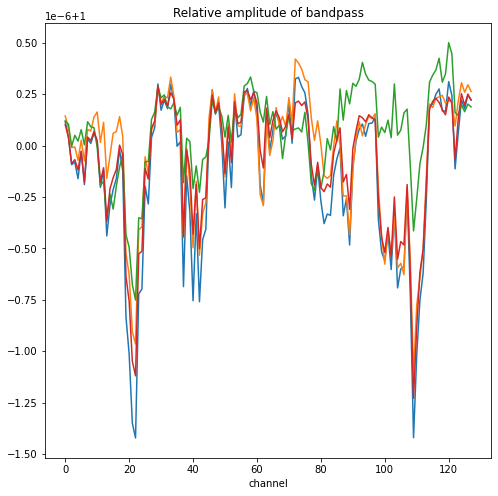

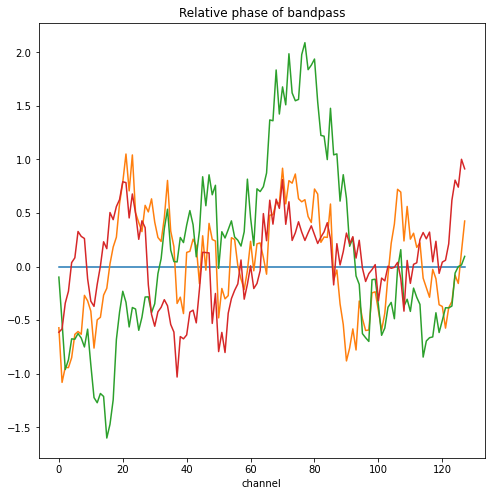

In [13]:
plt.clf()
for ant in range(4):
    amp = numpy.abs(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(amp)
plt.title('Relative amplitude of bandpass')
plt.xlabel('channel')
plt.show()

plt.clf()
for ant in range(4):
    refphase = numpy.angle(gtsol.gain[0,0,:,0,0]/gt.gain[0,0,:,0,0])
    phase = numpy.angle(gtsol.gain[0,ant,:,0,0]/gt.gain[0,ant,:,0,0])
    plt.plot(phase-refphase)
plt.title('Relative phase of bandpass')
plt.xlabel('channel')
plt.show()